### SVM Experiments – LinearSVC

In [6]:
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

# # Avoid convergence warnings spam
# import warnings
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

random_state = 42
results = []
partial_save_path = "results/svm_partial_results.csv"

### 1. Load Data

In [2]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

### 2. Prepare Data for LINEAR Models

In [3]:
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]
print("Fit complete.")

print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


### 3. Define Experiment Parameters

In [7]:
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

param = {
    "name": "LinearSVC",
    "params": {
        "random_state": random_state,
        "max_iter": 5000
    },
}

### 4. Run Experiment Loop

In [8]:
print("\nStarting LinearSVC experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        model_name = param["name"]
        params = param["params"]
        start_k_time = time.time()

        print(f"    ⏳ Running {model_name} ...", end="")
        sys.stdout.flush()

        model = LinearSVC(**params)
        
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        f1 = f1_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        prec = precision_score(y_test, y_pred, zero_division=0)
        acc = accuracy_score(y_test, y_pred)
        
        results.append(
            {
                "model": model_name,
                "ratio": ratio,
                "resample_type": resample_type.replace("df_",""),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
            }
        )

        print(
            f" done → F1={f1:.4f}, Recall={rec:.4f} | Time={time.time() - start_k_time:.1f}s"
        )
        sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting LinearSVC experiment loop...

[21:35:55] Starting ratio 1/7 → ratio=None
  [21:36:08] → Training on df_up (samples=1,296,675)
    ⏳ Running LinearSVC ... done → F1=0.0000, Recall=0.0000 | Time=13.5s
  [21:36:22] → Training on df_down (samples=1,296,675)
    ⏳ Running LinearSVC ... done → F1=0.0000, Recall=0.0000 | Time=13.3s
  💾 Saved intermediate results → results/svm_partial_results.csv
  ✅ Completed ratio=None in 0.7 min

[21:36:36] Starting ratio 2/7 → ratio=0.05
  [21:36:44] → Training on df_up (samples=1,353,627)
    ⏳ Running LinearSVC ... done → F1=0.3738, Recall=0.2779 | Time=13.9s
  [21:36:58] → Training on df_down (samples=157,626)
    ⏳ Running LinearSVC ... done → F1=0.3728, Recall=0.2769 | Time=1.7s
  💾 Saved intermediate results → results/svm_partial_results.csv
  ✅ Completed ratio=0.05 in 0.4 min

[21:36:59] Starting ratio 3/7 → ratio=0.1
  [21:37:05] → Training on df_up (samples=1,418,086)
    ⏳ Running LinearSVC ... done → F1=0.3285, Recall=0.3809 | Time=16.

### 5. Show Final Results

In [11]:
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing LinearSVC Models ---")
print(results_df.head(10))

results_df.to_csv("results/svm_results.csv", index=False)
print("\nSaved final results to results/svm_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing LinearSVC Models ---
        model  ratio resample_type  accuracy  precision    recall        f1
2   LinearSVC   0.05            up  0.996406   0.570881  0.277855  0.373785
3   LinearSVC   0.05          down  0.996403   0.570058  0.276923  0.372764
4   LinearSVC   0.10            up  0.993990   0.288795  0.380886  0.328508
5   LinearSVC   0.10          down  0.993882   0.282797  0.380886  0.324593
7   LinearSVC   0.20          down  0.985653   0.125739  0.456410  0.197160
6   LinearSVC   0.20            up  0.985561   0.124537  0.454545  0.195508
8   LinearSVC   0.30            up  0.979468   0.097629  0.524009  0.164592
9   LinearSVC   0.30          down  0.978966   0.094769  0.520280  0.160333
11  LinearSVC   0.50          down  0.953462   0.055645  0.692308  0.103011
10  LinearSVC   0.50            up  0.951855   0.053584  0.688578  0.099431

Saved final results to results/svm_results.csv


### 6. Plot Results


Generating plots...


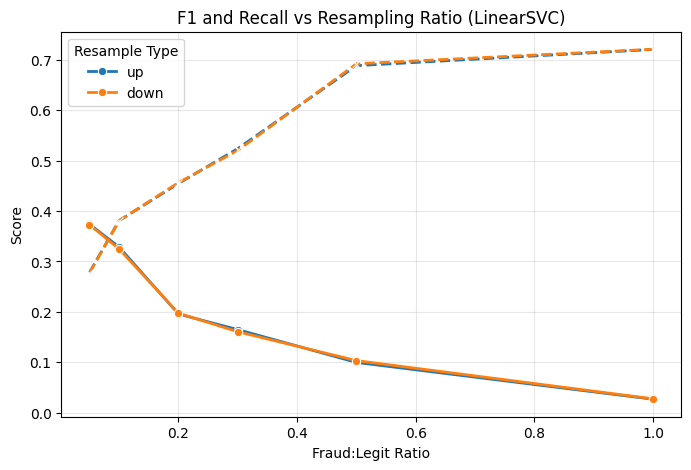


--- Mean Scores Summary ---
                     precision  recall     f1
ratio resample_type                          
0.05  down               0.570   0.277  0.373
      up                 0.571   0.278  0.374
0.10  down               0.283   0.381  0.325
      up                 0.289   0.381  0.329
0.20  down               0.126   0.456  0.197
      up                 0.125   0.455  0.196
0.30  down               0.095   0.520  0.160
      up                 0.098   0.524  0.165
0.50  down               0.056   0.692  0.103
      up                 0.054   0.689  0.099
1.00  down               0.014   0.721  0.027
      up                 0.013   0.721  0.026

Plots and summary complete.


In [10]:
print("\nGenerating plots...")

plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", marker="o", linewidth=2)
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", marker="x", linestyle="--", linewidth=2, legend=False)
plt.title("F1 and Recall vs Resampling Ratio (LinearSVC)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/svm_f1_recall_plot.png")
plt.show()


# ---- Summary Table ----
summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1"]].mean().round(3)
print("\n--- Mean Scores Summary ---")
print(summary)

print("\nPlots and summary complete.")